# GROUP A - Sentiment-based music recommender

This notebook contains code that we used to create sentiment and subjectivity scores from TextBlob and Turney Algorithm, "lyrics_sentiment.csv" dataset and visualizations.

## Content:
1. [TextBlob](#textblob)
2. [Turney Algorithm](#turney)
3. [Visualization code](#vis)

# Libraries

To run TextBlob you will need to install it from here: https://textblob.readthedocs.io/en/dev/

In [ ]:
import pandas as pd
import numpy as np
import os
from textblob import TextBlob # requires installation

import math
import re

import nltk 
from nltk import pos_tag
from nltk.corpus import stopwords
from wordcloud import WordCloud
from palettable.colorbrewer.diverging import Spectral_11  
from palettable.cmocean.diverging import Curl_20
from palettable.cartocolors.diverging import Temps_7
from palettable.cartocolors.sequential import SunsetDark_7
from palettable.lightbartlein.diverging import BlueGray_8
from palettable.cartocolors.qualitative import Pastel_10
import matplotlib.pyplot as plt
import seaborn as sns

# TextBlob - sentiment analysis <a id='textblob'>

In [5]:
lyrics = pd.read_csv('lyrics.csv', index_col='index')

lyrics = lyrics[lyrics.lyrics.notnull()]
lyrics = lyrics[(lyrics.genre!='Not Available') & (lyrics.genre!= 'Other')]
lyrics = lyrics[lyrics.year >= 2010]

lyrics.groupby(['year', 'genre']).lyrics.count().unstack()

genre,Country,Electronic,Folk,Hip-Hop,Indie,Jazz,Metal,Pop,R&B,Rock
year,,,,,,,,,,
2010,360,439,106,1537,159,306,655,1798,51,3421
2011,287,431,57,1474,240,228,613,2259,85,2995
2012,301,385,190,1778,223,346,594,1939,71,3170
2013,522,538,111,1229,240,393,566,1978,163,2671
2014,535,660,96,1324,380,698,583,2611,208,3697
2015,406,478,77,1161,331,420,431,1999,273,2371
2016,414,506,102,1508,260,585,497,1839,223,2624


In [ ]:
def get_text_blob_metrics(lyrics):
    blob = TextBlob(lyrics)
    
    pol = []
    subj = []
    
    for sentence in blob.sentences:
        pol.append(sentence.sentiment.polarity)
        subj.append(sentence.sentiment.subjectivity)
        
    polarity_mean = np.mean(pol)
    polarity_std = np.std(pol)
    
    subjectivity_mean = np.mean(subj)
    subjectivity_std = np.std(subj)
    
    return pd.Series((polarity_mean, polarity_std, subjectivity_mean, subjectivity_std))

In [ ]:
lyrics[['polarity_avg', 'polarity_std', 'subjectivity_avg', 'subjectivity_std']] = lyrics.apply(lambda row: get_text_blob_metrics(row.lyrics), axis=1)

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=lyrics, x='polarity_avg', y='subjectivity_avg', hue='genre')
plt.savefig('map_songs.png')
plt.show()

### Save it for later use

In [ ]:
lyrics.to_csv('lyrics_sentiment.csv')

# Turney Algorithm <a id='turney'>

In this notebook we will implement the Turney Algorithm (proposed by Peter D. Turney: http://www.aclweb.org/anthology/P02-1053.pdf) for automatically create a sentiment lexicon from our data. The algorithm is trained on the IMDB dataset and predicts on the test dataset

### Train Dataset

You will need to download IMDB dataset from the following link: 
http://ai.stanford.edu/~amaas/data/sentiment/

In [73]:

#Juliana
data_path = "imdb/"
path_pos = data_path + "pos"
path_neg = data_path + "neg"

pos_filenames = os.listdir(path_pos)
neg_filenames = os.listdir(path_neg)

contents=[]
# Read the text in the positive files
for f in pos_filenames:
    with open (path_pos+ "/" +f) as txt:
        for line in txt:
            contents.append(line)
        
# Read the text in the negativee files
for f in neg_filenames:
    with open (path_neg+ "/" +f) as txt:
        for line in txt:
            contents.append(line)
                  
# Join the whole contents and split it by word
res='\n'.join(contents).split()

In [74]:
res[:10]

['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the']

As seen in class, the first step was based on extracting two-word phrases with adjectives. To allow this, we have to first annotate the words with the POS tagging.

We use the `pos_tag` function implemented into NLTK

In [75]:
pos_tags=pos_tag(res)

In [76]:
pos_tags[:10]

[('Bromwell', 'NNP'),
 ('High', 'NNP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('cartoon', 'NN'),
 ('comedy.', 'NN'),
 ('It', 'PRP'),
 ('ran', 'VBD'),
 ('at', 'IN'),
 ('the', 'DT')]

Now we define a function to find the patterns defined in the paper.

    |First Word    |Second Word    |Third Word (not extracted)|
    ***********************************************************
    |JJ	        |NN or NNS	  |anything                  |
    |RB, RBR, RBS  |JJ	         |Not NN nor NNS            |
    |JJ	        |JJ	         |Not NN or NNS             |
    |NN or NNS	 |JJ	         |Nor NN nor NNS            |
    |RB,RBR or RBS |VB,VBD,VBN,VBG |anything                  |
    ***********************************************************


In [77]:
def find_pattern(postag):
    tag_pattern = []  
    for k in range(len(postag)-2):
        if( postag[k][1]=="JJ" and postag[k+1][1]=="JJ" and postag[k+2][1]!="NN" and postag[k+2][1]!="NNS"):
            tag_pattern.append("".join(postag[k][0])+" "+"".join(postag[k+1][0]))
        if( (postag[k][1]=="NN" or postag[k][1]=="NNS") and postag[k+1][1]=="JJ" and postag[k+2][1]!="NN" and postag[k+2][1]!="NNS"):
            tag_pattern.append("".join(postag[k][0])+" "+"".join(postag[k+1][0]))
        if( (postag[k][1]=="RB" or postag[k][1]=="RBR" or postag[k][1]=="RBS") and postag[k+1][1]=="JJ" and postag[k+2][1]!="NN" and postag[k+2][1]!="NNS"):
            tag_pattern.append("".join(postag[k][0])+" "+"".join(postag[k+1][0]))
        if( (postag[k][1]=="RB" or postag[k][1]=="RBR" or postag[k][1]=="RBS") and (postag[k+1][1]=="VB" or postag[k+1][1]=="VBN" or postag[k+1][1]=="VBD" or postag[k+1][1]=="VBG")):
            tag_pattern.append("".join(postag[k][0])+" "+"".join(postag[k+1][0])) 
        if( postag[k][1]=="JJ" and postag[k+1][1]=="NN" ) or ( postag[k][1]=="JJ" and postag[k+1][1]=="NNS" ):
            tag_pattern.append("".join(postag[k][0])+" "+"".join(postag[k+1][0]))
    return tag_pattern

Use the function to store all phrases that satisfy the conditions


In [78]:
tag_pattern = find_pattern(pos_tags)
tag_pattern = list(set(tag_pattern))
tag_pattern[:10]

['absolutely implausible.',
 'great writer',
 'not imaginative.',
 'sunken WWII',
 "stimulating, it's",
 'over-dramatic music,',
 'few days',
 "human beings'",
 'unique merits',
 'still shouting']

Now we create three data structures to facilitate the algorithm execution

- **mat_phrase_great:** numpy matrix of hits between each phrase and the word great
- **mat_phrase_poor:** hits between phrase and poor in each file
- **mat_phrase_count:** matrix storing 1 if a phrase is present in a file. used for adding corresponding SOs later.
- **hits_great:** stores total hits of great in training set for each fold, correspondingly **hits_poor** stores poor hits


In [79]:
mat_phrase_great= np.zeros((len(tag_pattern), len(pos_filenames) + len(neg_filenames)), dtype="int8")
mat_phrase_poor= np.zeros((len(tag_pattern),  len(pos_filenames) + len(neg_filenames)), dtype="int8")
mat_phrase_count=np.zeros((len(tag_pattern), len(pos_filenames) + len(neg_filenames)), dtype="int8")
hits_great=[]
hits_poor=[]

The following counts the ocurrence of the words `poor` and `great` in the positive files.

Be patient! it is going to take a while

In [80]:
import string

for cnt, fi in enumerate(pos_filenames):
    with open (path_pos + "/" +fi) as cf:
        txt=cf.read()
        txt = "".join(l for l in txt if l not in string.punctuation)
        file_list=txt.split()
        hits_great.append(file_list.count("great"))
        hits_poor.append(file_list.count("poor"))

        for j in range(len(tag_pattern)):
            all_hit_phrase_index=[]
            hits_phrase_great=0
            hits_phrase_poor=0
            if (tag_pattern[j] in txt):
                mat_phrase_count[j][cnt]=1
                try:
                    for w in (file_list):
                        if (w==tag_pattern[j].split()[0]):
                            ind=file_list.index(w)
                            if(file_list[ind+1]==tag_pattern[j].split()[1]):
                                #print(ind)
                                all_hit_phrase_index.append(ind)
                        for ids in (all_hit_phrase_index):
                            #print(all_hit_index)
                            for words in file_list[ids-10 :ids+11]:
                                if words=="great":
                                    hits_phrase_great+=1
                                if words=="poor":
                                    hits_phrase_poor+=1
                        mat_phrase_great[j][cnt]=hits_phrase_great
                        mat_phrase_poor[j][cnt]=hits_phrase_poor
                except:
                        pass

The same for the negative files

In [81]:
for cnt, fi in enumerate(neg_filenames):    
    with open (path_neg + "/" +fi) as cf:
            txt=cf.read()
            file_list=txt.split()
            hits_great.append(file_list.count("great"))
            hits_poor.append(file_list.count("poor"))
            for j in range(len(tag_pattern)):
                all_hit_phrase_index=[]
                hits_phrase_great=0
                hits_phrase_poor=0
                if (tag_pattern[j] in txt):
                    mat_phrase_count[j][cnt]=1
                    try:
                        for w in (file_list):
                            if (w==tag_pattern[j].split()[0]):
                                ind=file_list.index(w)
                                if(file_list[ind+1]==tag_pattern[j].split()[1]):
                                    #print(ind)
                                    all_hit_phrase_index.append(ind)
                        for ids in (all_hit_phrase_index):
                            #print(all_hit_phrase_index)
                            for words in file_list[ids-10 :ids+11]:
                                if words=="great":
                                    hits_phrase_great+=1
                                if words=="poor":
                                    hits_phrase_poor+=1                     
                        mat_phrase_great[j][cnt]=hits_phrase_great
                        mat_phrase_poor[j][cnt]=hits_phrase_poor
                    except:
                            pass


In [102]:
"""10 Fold Cross-Validation"""
from sklearn.model_selection import KFold

kf=KFold(n_splits=10, shuffle=True)

# Join the negative and positive filenames
file_names=os.listdir(path_pos)+os.listdir(path_neg)

for train, test_data in kf.split(file_names):  ##for each fold in the 10 fold CV
    tr_great= mat_phrase_great[: , train[0]:train[-1]]
    phrase_hit_great=np.sum(tr_great, axis=1)
    tr_poor= mat_phrase_poor[: , train[0]:train[-1]]
    phrase_hit_poor=np.sum(tr_poor, axis=1)
   
    hits_gr=sum(hits_great[train[0]:train[-1]])
    hits_po=sum(hits_poor[train[0]:train[-1]])
   
    semantic_orientation(phrase_hit_great, phrase_hit_poor, hits_gr, hits_po, test_data)   
    
acc_avg=sum(acc_all)/float(10)
print("[INFO] Accuracy: %r " %(acc_avg))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log2
  


[INFO] Accuracy: 0.0 


### Test Dataset

In [109]:
# load the datafram

df = pd.read_csv(os.path.join(data_path,'lyrics_sentiment.csv'))

In [110]:
# replace line separator

df['lyrics'] = df['lyrics'].str.replace("\n", " ")

In [111]:
#Lowercasing words

df['lyrics'] = df['lyrics'].str.lower()

In [112]:
#punctuation signs: eliminating them as they will not have any prediction power

punctuation_signs = list("?:!.,;@[]()''")
for punct_sign in punctuation_signs:
    df['lyrics'] = df['lyrics'].str.replace(punct_sign, '')

In [113]:
#check

df.head()

,index,song,year,artist,genre,lyrics,polarity_avg,polarity_std,subjectivity_avg,subjectivity_std
0,55,back-to-black,2013,beyonce-knowles,Pop,andre 3000 i i i left no time to regret kept m...,0.042000,0.000000,0.364389,0.000000
1,56,mine,2013,beyonce-knowles,Pop,verse 1 beyonce ive been watching for the sign...,0.196679,0.106895,0.502837,0.120348
2,57,superpower,2013,beyonce-knowles,Pop,verse 1 when the palm of my two hands hold eac...,0.039610,0.000000,0.535494,0.000000
3,58,haunted,2013,beyonce-knowles,Pop,intro presenter the winner is beyonce knowles ...,0.050000,0.198206,0.309524,0.320077
4,59,flawless,2013,beyonce-knowles,Pop,intro your challengers are a young group from ...,0.376966,0.334521,0.613072,0.145711


In [114]:
# copy of test data for rest of the work

test_data = df.copy()

In [115]:
# verify

test_data.head()

,index,song,year,artist,genre,lyrics,polarity_avg,polarity_std,subjectivity_avg,subjectivity_std
0,55,back-to-black,2013,beyonce-knowles,Pop,andre 3000 i i i left no time to regret kept m...,0.042000,0.000000,0.364389,0.000000
1,56,mine,2013,beyonce-knowles,Pop,verse 1 beyonce ive been watching for the sign...,0.196679,0.106895,0.502837,0.120348
2,57,superpower,2013,beyonce-knowles,Pop,verse 1 when the palm of my two hands hold eac...,0.039610,0.000000,0.535494,0.000000
3,58,haunted,2013,beyonce-knowles,Pop,intro presenter the winner is beyonce knowles ...,0.050000,0.198206,0.309524,0.320077
4,59,flawless,2013,beyonce-knowles,Pop,intro your challengers are a young group from ...,0.376966,0.334521,0.613072,0.145711


In [116]:
#select 2001 random rows for the work

random_selections = np.random.choice(test_data.index,size=2000)

In [117]:
# put the indices and lyrics into a list

test_data = list(test_data.loc[random_selections,'lyrics'])

In [118]:
# verify the first lyrics

test_data[1]

'i was always looking for lady but baby youre so far away if i could only call you my lady baby i could be your man wise men they say only fools fall in love why do we fall in love baby i just want you to come back and give us all something to do give us all something to do if you could only feel the flame from the candle i burn for you lady if you want me to come back ill come running back to you but baby if you ask me to come back youve got to give me something to do'

In [119]:
# create a list with all the words from the lyrics

res = res='\n'.join(test_data).split()

In [120]:
#create pos tags
pos_tags=pos_tag(res)

In [121]:
# view pos tags

pos_tags[:10]

[('i', 'NN'),
 ('walked', 'VBD'),
 ('from', 'IN'),
 ('new', 'JJ'),
 ('york', 'NN'),
 ('and', 'CC'),
 ('back', 'RB'),
 ('from', 'IN'),
 ('la', 'NN'),
 ('i', 'NN')]

Now we define a function to find the patterns defined in the paper.

    |First Word    |Second Word    |Third Word (not extracted)|
    ***********************************************************
    |JJ	        |NN or NNS	  |anything                  |
    |RB, RBR, RBS  |JJ	         |Not NN nor NNS            |
    |JJ	        |JJ	         |Not NN or NNS             |
    |NN or NNS	 |JJ	         |Nor NN nor NNS            |
    |RB,RBR or RBS |VB,VBD,VBN,VBG |anything                  |
    ***********************************************************


In [122]:
def find_pattern(postag):
    tag_pattern = []  
    for k in range(len(postag)-2):
        if( postag[k][1]=="JJ" and postag[k+1][1]=="JJ" and postag[k+2][1]!="NN" and postag[k+2][1]!="NNS"):
            tag_pattern.append("".join(postag[k][0])+" "+"".join(postag[k+1][0]))
        if( (postag[k][1]=="NN" or postag[k][1]=="NNS") and postag[k+1][1]=="JJ" and postag[k+2][1]!="NN" and postag[k+2][1]!="NNS"):
            tag_pattern.append("".join(postag[k][0])+" "+"".join(postag[k+1][0]))
        if( (postag[k][1]=="RB" or postag[k][1]=="RBR" or postag[k][1]=="RBS") and postag[k+1][1]=="JJ" and postag[k+2][1]!="NN" and postag[k+2][1]!="NNS"):
            tag_pattern.append("".join(postag[k][0])+" "+"".join(postag[k+1][0]))
        if( (postag[k][1]=="RB" or postag[k][1]=="RBR" or postag[k][1]=="RBS") and (postag[k+1][1]=="VB" or postag[k+1][1]=="VBN" or postag[k+1][1]=="VBD" or postag[k+1][1]=="VBG")):
            tag_pattern.append("".join(postag[k][0])+" "+"".join(postag[k+1][0])) 
        if( postag[k][1]=="JJ" and postag[k+1][1]=="NN" ) or ( postag[k][1]=="JJ" and postag[k+1][1]=="NNS" ):
            tag_pattern.append("".join(postag[k][0])+" "+"".join(postag[k+1][0]))
    return tag_pattern

Use the function to store all phrases that satisfy the conditions


In [123]:
tag_pattern = find_pattern(pos_tags)
tag_pattern = list(set(tag_pattern))
tag_pattern[:10]

['so tuff',
 'point strong',
 'still cold',
 'deny theres',
 'viral y',
 'yo brain',
 'shine ive',
 'viel erzielen',
 'hard wood',
 'exotic possibilities']

Now we create three data structures to facilitate the algorithm execution

- **mat_phrase_great:** numpy matrix of hits between each phrase and the word great
- **mat_phrase_poor:** hits between phrase and poor in each file
- **mat_phrase_count:** matrix storing 1 if a phrase is present in a file. used for adding corresponding SOs later.
- **hits_great:** stores total hits of great in training set for each fold, correspondingly **hits_poor** stores poor hits


In [124]:
mat_phrase_great= np.zeros((len(tag_pattern), len(pos_filenames) + len(neg_filenames)), dtype="int8")
mat_phrase_poor= np.zeros((len(tag_pattern),  len(pos_filenames) + len(neg_filenames)), dtype="int8")
mat_phrase_count=np.zeros((len(tag_pattern), len(pos_filenames) + len(neg_filenames)), dtype="int8")
hits_great=[]
hits_poor=[]

The following counts the ocurrence of the words `poor` and `great` in the positive files.

In [125]:
import string

#for cnt, fi in enumerate(pos_filenames):
 #   with open (path_pos + "\\" +fi) as cf:

for cnt, text in enumerate(test_data):    
        txt= text
        txt = "".join(l for l in txt if l not in string.punctuation)
        file_list=txt.split()
        hits_great.append(file_list.count("great"))
        hits_poor.append(file_list.count("poor"))

        for j in range(len(tag_pattern)):
            all_hit_phrase_index=[]
            hits_phrase_great=0
            hits_phrase_poor=0
            if (tag_pattern[j] in txt):
                mat_phrase_count[j][cnt]=1
                try:
                    for w in (file_list):
                        if (w==tag_pattern[j].split()[0]):
                            ind=file_list.index(w)
                            if(file_list[ind+1]==tag_pattern[j].split()[1]):
                                #print(ind)
                                all_hit_phrase_index.append(ind)
                        for ids in (all_hit_phrase_index):
                            #print(all_hit_index)
                            for words in file_list[ids-10 :ids+11]:
                                if words=="great":
                                    hits_phrase_great+=1
                                if words=="poor":
                                    hits_phrase_poor+=1
                        mat_phrase_great[j][cnt]=hits_phrase_great
                        mat_phrase_poor[j][cnt]=hits_phrase_poor
                except:
                        pass

In [126]:
acc_all=[]
preds = []
def semantic_orientation(p_hit_great, p_hit_poor, hits_gr, hits_po, test_data):
    num=(p_hit_great*float(hits_po))+0.01
    den=(p_hit_poor*float(hits_gr))+0.01
    so=np.log2(np.divide(num, den)) #PMI
    so=np.nan_to_num(so) # Change nan to 0 to avoid errors
    acc=0.0
    fold_no=0
    for f in test_data:
        polarity=0.0
        
        #if f<1000:
         #   correct_label="positive"
            
        #if f>=1000:
         #   correct_label="negative"
        
        for p in range(len(so)):
            if mat_phrase_count[p][f]==1:
                polarity+=so[p]
                
        if (polarity>=0.1): # Confidence threshold
            pred="positive"
            
        else:
            pred="negative"
        
        preds.append(pred)
        
        #if(pred==correct_label):
         #    acc+=1
             
    #acc=acc/float(200)
    #acc_all.append(acc)
    
    #print("[INFO] Fold accuracy: %r" %(acc))               
    #fold_no+=1

In [127]:
"""10 Fold Cross-Validation"""
from sklearn.model_selection import KFold

# Join the negative and positive filenames

for train,test_data in kf.split(test_data):  ##for each fold in the 10 fold CV
    tr_great= mat_phrase_great[: , train[0]:train[-1]]
    phrase_hit_great=np.sum(tr_great, axis=1)
    tr_poor= mat_phrase_poor[: , train[0]:train[-1]]
    phrase_hit_poor=np.sum(tr_poor, axis=1)
   
    hits_gr=sum(hits_great[train[0]:train[-1]])
    hits_po=sum(hits_poor[train[0]:train[-1]])
   
    semantic_orientation(phrase_hit_great, phrase_hit_poor, hits_gr, hits_po, test_data)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log2
  


In [128]:
# create a polarity column on the main dataset with anything above 10% as a threshold for positive

polarity_nltk = []

for polarity in df.loc[random_selections,'polarity_avg']:
    if polarity >= 0.1:
        polarity_nltk.append('positive')
    else:
        polarity_nltk.append('negative')

In [129]:
len(preds)

2001

In [130]:
# create two columns, one with the polarity using text blob and another 

df = df.loc[random_selections,:]

df['polarity_nltk'] = polarity_nltk
df['polarity_turney'] = preds

In [131]:
# how many matches?

result_1 = ((df['polarity_nltk']) == (df['polarity_turney'])).sum() /2000

In [132]:
# value count for turney

result_1_turney = df['polarity_turney'].value_counts() / 2000

In [133]:
# value count for text blob

result_1_nltk = df['polarity_nltk'].value_counts() / 2000

In [134]:
# all results


result_1, result_1_nltk,result_1_turney

(0.6005, negative    0.6210
 positive    0.3795
 Name: polarity_nltk, dtype: float64, negative    0.8630
 positive    0.1375
 Name: polarity_turney, dtype: float64)

# Visualization <a id='vis'>

In [58]:
# build a list of all the stopwords
nltk.download('stopwords')
stop_words_en = list(stopwords.words('english'))
stop_words_fr = list(stopwords.words('french'))
stop_words_es = list(stopwords.words('spanish'))
stop_words_gr = list(stopwords.words('german'))
stop_words_extras = ['chorus','intro','verse']
stop_words = stop_words_en + stop_words_fr + stop_words_es + stop_words_extras

# use list to remove stopwords
df['lyrics'] = df.lyrics.apply(lambda x: str(x)) 
df['lyrics'] = df.lyrics.apply(lambda x: ([x for x in x.split() if x not in stop_words]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julianavillaveces/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
# create a copy to work with

df2 = df.copy()

In [60]:
genre = df2.lyrics # all lyrics
genre_pop= df2.lyrics.groupby(df['genre']=='Pop') #pop lyrics
genre_rock= df2.lyrics.groupby(df['genre']=='Rock') # rock lyrics 
genre_hip= df2.lyrics.groupby(df['genre']=='Hip-Hop') # hip hop lyrics
genre_metal= df2.lyrics.groupby(df['genre']=='Metal') #metal lyrics
genre_country= df2.lyrics.groupby(df['genre']=='Country') # country lyriics


In [62]:
# join all values in genre

genre = genre.apply(lambda x: str(x)) 
genre = ''.join(genre)

# join all values in pop

genre_pop = genre_pop.apply(lambda x: str(x)) 
genre_pop = ''.join(genre_pop)

# join all values in rock

genre_rock = genre_rock.apply(lambda x: str(x)) 
genre_rock = ''.join(genre_rock)

# join all values in hip hop

genre_hip = genre_hip.apply(lambda x: str(x)) 
genre_hip = ''.join(genre_hip)


# join all values in metal
genre_metal = genre_metal.apply(lambda x: str(x)) 
genre_metal = ''.join(genre_metal)

# join all values in country

genre_country = genre_country.apply(lambda x: str(x)) 
genre_country = ''.join(genre_country)

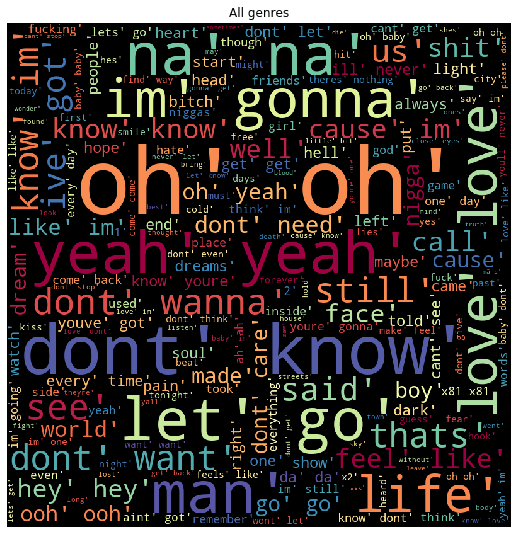

In [64]:
# Plot for all the genres


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10, colormap = Spectral_11.mpl_colormap).generate(genre) 
  
# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('All genres')
  
plt.show() 

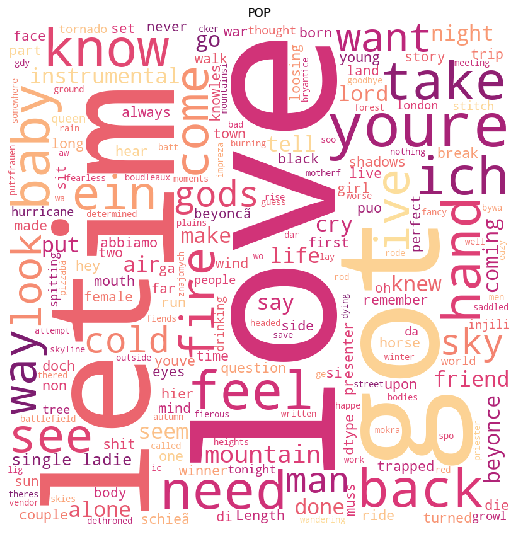

In [65]:
# Plot for pop

wordcloud_pop = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, colormap = SunsetDark_7.mpl_colormap).generate(genre_pop) 
  
# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud_pop) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('POP')
  
plt.show()

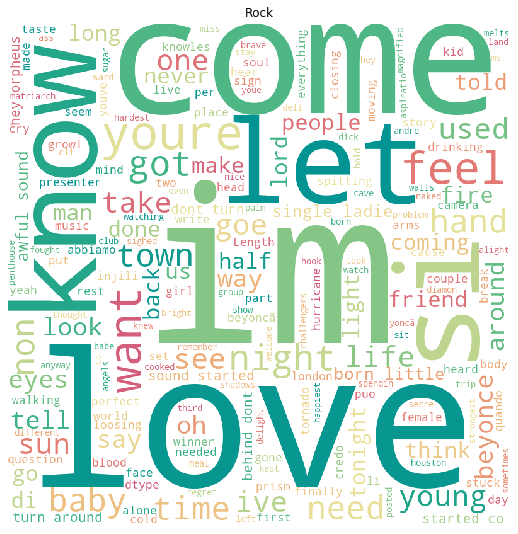

In [66]:
# Plot for rock

wordcloud_rock = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, colormap = Temps_7.mpl_colormap).generate(genre_rock) 
  
# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud_rock) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Rock')
  
plt.show()


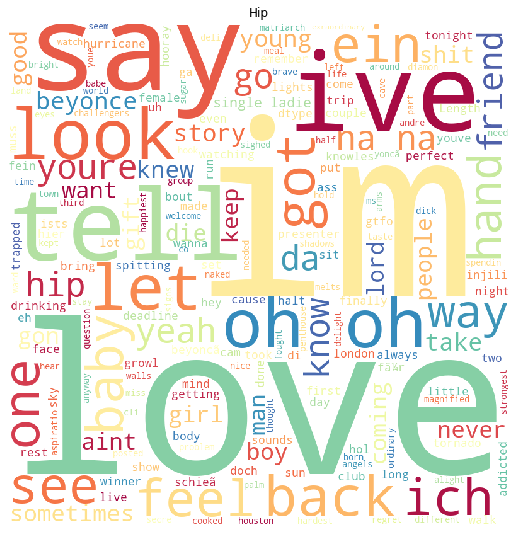

In [67]:
# Plot for hip hop

wordcloud_hip = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, colormap = Spectral_11.mpl_colormap).generate(genre_hip) 
  
# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud_hip) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Hip')
  
plt.show() 

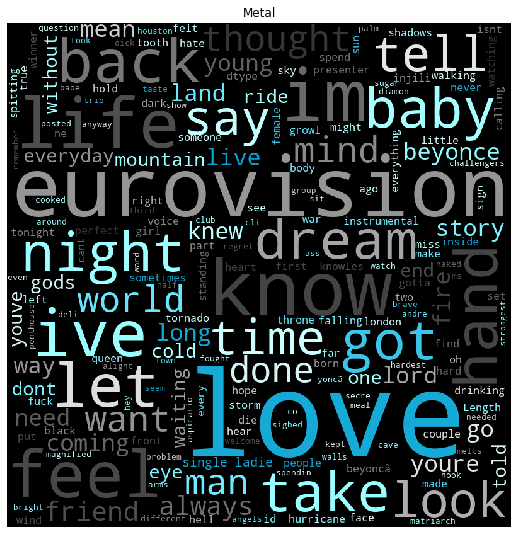

In [68]:
# Plot for metal

wordcloud_metal = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10, colormap = BlueGray_8.mpl_colormap).generate(genre_metal) 
  
# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud_metal) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Metal')
  
plt.show() 

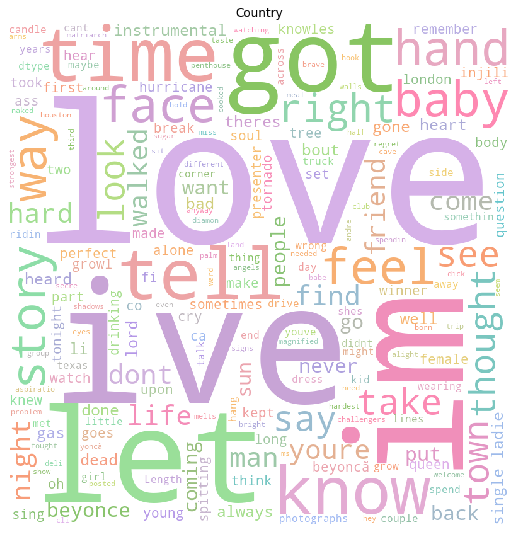

In [69]:
# Plot for country

wordcloud_country = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, colormap = Pastel_10.mpl_colormap).generate(genre_country) 
  
# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud_country) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Country')
  
plt.show() 